In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

/Users/yhtgrace/anaconda3/envs/nozdormu/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [4]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [5]:
query = """
SELECT * FROM icu_features
"""
ef_ = pd.read_sql_query(query, con)
ef_.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,ethnicity,insurance,filter_vaso,...,pc_bronch,pc_cath,pc_echo,pc_pressor,pc_rhc,pc_thora,pc_vent,passed_filters,use_record,bmi
0,200001,152234,55973,22290 days 19:06:12,F,167.851667,27.669135,ASIAN - ASIAN INDIAN,Medicare,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9.820741
1,200003,163557,27513,17625 days 19:50:04,M,177.800000,78.224998,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.744692
2,200006,189514,10950,19736 days 11:28:14,M,165.100000,82.400002,OTHER,Medicaid,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.229647
3,200007,129310,20707,15818 days 10:03:37,M,177.800000,126.000000,WHITE,Private,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.857223
4,200009,129607,29904,17353 days 10:34:32,F,160.020000,85.833331,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.520264


In [6]:
len(ef_)

61532

In [7]:
use_record = (ef_['use_record'] == 1)
has_echo = ~ef_['ea_key'].isnull()

time_filter = (((ef_['ed_charttime'] - ef_['intime']) > np.timedelta64(8, 'h')) &
               ((ef_['ed_charttime'] - ef_['intime']) < np.timedelta64(48, 'h')))

F = use_record & has_echo & time_filter

In [8]:
ef_ = ef_.loc[F]

len(ef_)

2169

# Preprocesing

In [9]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [10]:
value = mdrd(ef_)
ef_['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef_['mdrd_discrete'] = discrete
discrete.value_counts()

0    491
1    438
4    362
2    358
3    324
5    171
dtype: int64

In [35]:
def normalize(x):
    x = x.copy()
    I = ~np.isnan(x)
    x[I] = (x[I] - x[I].mean())/x[I].std()
    return x

ef = ef_.copy()

X = pd.DataFrame()

# build the features table
age = ef.age/np.timedelta64('1', 'Y') # time in years
age_masked = age < 0 # if age is less than 0, then the person is above 89 (90?)
age = normalize(age)
age[age_masked] = 0
X['age'] = age
X['age_over_90'] = age_masked.astype(float)

gender = ef.gender
gender = (gender == 'F').astype(float)
X['gender'] = gender

bmi = ef.bmi
bmi_missing = np.isnan(bmi)
bmi = normalize(bmi)
bmi[bmi_missing] = 0
X['bmi'] = bmi
X['bmi_missing'] = bmi_missing.astype(float)

mech_vent = ef.vf_first_day_vent.astype(float)
X['mech_vent'] = mech_vent

chf = ef.ex_congestive_heart_failure.astype(float)
X['CHF'] = chf

mdrd = ef.mdrd
mdrd_missing = np.isnan(mdrd)
mdrd = normalize(mdrd)
mdrd[mdrd_missing] = 0
X['mdrd'] = mdrd

# MDRD missing is already largely covered by BMI missing
# the only other missing values come from missing creatinine lab
# so add that
creatinine_missing = np.isnan(ef.lab_creatinine)
X['creatinine_missing'] = creatinine_missing.astype(float)

apsiii = ef.apsiii
#apsiii_missing = np.isnan(apsiii)
apsiii = normalize(apsiii)
#apsiii[apsiii_missing] = 0
X['apsiii'] = apsiii
#X['apsiii_missing'] = apsiii_missing.astype(float)

no_echo = np.isnan(ef.ea_key)
#X['no_echo'] = no_echo.astype(float)

# -3 cannot assess
# -2 ?depressed
# -1 hyper
# 0 normal
# 1 mildly depressed
# 2 moderately depressed
# 3 severe
lvsys = ef.ea_lv_systolic
lv_missing = (((np.isnan(lvsys)) | (lvsys < -2)) & ~no_echo).astype(float)
lv_hyperdynamic = (lvsys == -1).astype(float)
lv_normal = (lvsys == 0).astype(float)
lv_mild = (lvsys == 1).astype(float)
lv_depressed = ((lvsys == 2) | (lvsys == -2)).astype(float)
lv_sev_depressed = (lvsys == 3).astype(float)
X['lv_missing'] = lv_missing
X['lv_normal'] = lv_normal 
X['lv_mild'] = lv_mild
X['lv_hyper'] = lv_hyperdynamic
X['lv_depressed'] = lv_depressed
X['lv_severe'] = lv_sev_depressed

# -3 cannot assess
# -2 PA systolic hypertension
# 0 normal
# 1 mild
# 2 moderate
# 3 severe
tvpulm = ef.ea_tv_pulm_htn
tv_missing = (((np.isnan(tvpulm)) | (tvpulm < -2)) & ~no_echo).astype(float)
tv_normal = (tvpulm == 0).astype(float)
tv_abnormal = ((tvpulm == -2) | (tvpulm > 0)).astype(float)
X['plm_htn_missing'] = tv_missing
X['plm_htn_normal'] = tv_normal
X['plm_htn_abnormal'] = tv_abnormal

# -3 cannot assess 
# -2 dilated
# -1 small
# 0 normal
# 1 mildly dilated
# 2 moderately dilated
rvcavity = ef.ea_rv_cavity
rvcav_missing = (((np.isnan(rvcavity) | (rvcavity < -2))) & ~no_echo).astype(float)
rvcav_normal = (rvcavity == 0).astype(float)
rvcav_small = (rvcavity == -1).astype(float)
rvcav_dilated = ((rvcavity == -2) | (rvcavity > 0)).astype(float)
X['rvcav_missing'] = rvcav_missing
X['rvcav_normal'] = rvcav_normal
X['rvcav_small'] = rvcav_small
X['rvcav_dilated'] = rvcav_dilated

lactate = ef.lab_lactate
lactate_missing = np.isnan(lactate)
lactate = normalize(lactate)
lactate[lactate_missing] = 0
X['lactate'] = lactate
X['lactate_missing'] = lactate_missing.astype(float)

## which ICU was treating the patient
sicu = ef.st_sicu.astype(float)
sicu[np.isnan(sicu)] = 0
nsicu = ef.st_nsicu.astype(float)
nsicu[np.isnan(nsicu)] = 0
micu = ef.st_micu.astype(float)
micu[np.isnan(micu)] = 0
#X['sicu'] = sicu
#X['nsicu'] = nsicu
X['micu'] = micu

## on vasopressors
on_vaso = ef.filter_vaso.astype(float)
X['on_vaso'] = on_vaso

## fluids
fluid_day1 = ef.fb_day1_balance_ml.values.copy()
f1_missing = np.isnan(fluid_day1)
fluid_day1[~f1_missing] = normalize(fluid_day1[~f1_missing])
fluid_day1[f1_missing] = 0
X['fluid_day1'] = fluid_day1
X['fluid_day1_missing'] = f1_missing.astype(float)

fluid_day2 = ef.fb_day2_balance_ml.values.copy()
f2_missing = np.isnan(fluid_day1) | np.isnan(fluid_day2)
fluid_day2[~f2_missing] = normalize(fluid_day2[~f2_missing])
fluid_day2[f2_missing] = 0
X['fluid_day2'] = fluid_day2
X['fluid_day2_missing'] = f2_missing.astype(float)

fluid_day3 = ef.fb_day3_balance_ml.values.copy()
f3_missing = np.isnan(fluid_day1) | np.isnan(fluid_day2) | np.isnan(fluid_day3)
fluid_day3[~f3_missing] = normalize(fluid_day3[~f3_missing])
fluid_day3[f3_missing] = 0
X['fluid_day3'] = fluid_day3
X['fluid_day3_missing'] = f3_missing.astype(float)

X['outcome'] = ((ef.dod - ef.intime) < np.timedelta64(30, 'D')).astype(int)

In [36]:
X.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,lactate_missing,micu,on_vaso,fluid_day1,fluid_day1_missing,fluid_day2,fluid_day2_missing,fluid_day3,fluid_day3_missing,outcome
1,0.107313,0.0,0.0,0.002856,0.0,1.0,0.0,0.612350,0.0,-0.365966,...,0.0,0.0,0.0,0.092432,0.0,-0.269433,0.0,0.000000,1.0,0
46,0.073491,0.0,1.0,0.142779,0.0,1.0,0.0,-0.893403,0.0,2.972322,...,0.0,1.0,0.0,0.006236,0.0,0.038370,0.0,-0.319005,0.0,0
60,0.278241,0.0,0.0,-0.099502,0.0,1.0,1.0,0.951676,0.0,-0.091586,...,0.0,1.0,0.0,-0.867218,0.0,-0.650015,0.0,-0.536243,0.0,0
68,0.087456,0.0,0.0,0.181029,0.0,1.0,0.0,-0.789499,0.0,1.234583,...,0.0,0.0,0.0,0.595252,0.0,-0.279106,0.0,-1.465937,0.0,1
78,0.194886,0.0,0.0,-0.078058,0.0,0.0,1.0,-0.284870,0.0,-0.548886,...,0.0,1.0,1.0,0.012617,0.0,0.000000,1.0,0.000000,1.0,0


In [37]:
import feather
feather.write_dataframe(X, "../data/170605_preprocessing.feather")

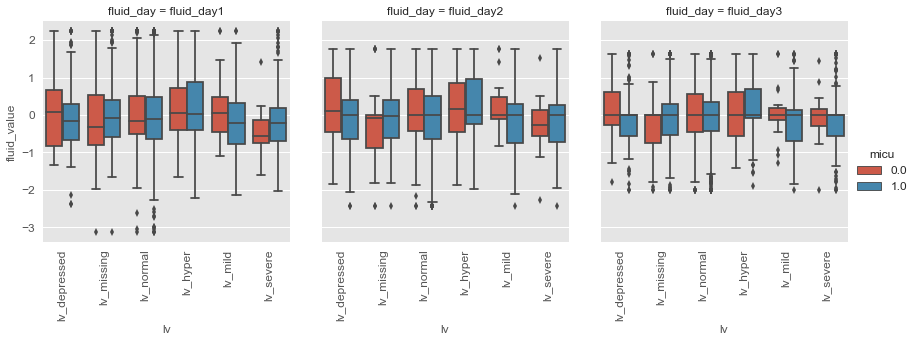

In [49]:
to_plot = X[['fluid_day1', 'fluid_day2', 'fluid_day3']].stack().reset_index(level = 1)
to_plot.columns = ['fluid_day', 'fluid_value']
to_plot['lv'] = X[['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_depressed', 'lv_severe']].idxmax(axis = 1)
to_plot['micu'] = X['micu']

g = sns.factorplot(kind = 'box', data = to_plot, x = 'lv', y = 'fluid_value', col = 'fluid_day', hue = 'micu')
for ax in g.axes[0]: 
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

In [54]:
to_plot.loc[to_plot['fluid_day'] == 'fluid_day1'].groupby(['lv', 'micu']).count()

fluid_day  fluid_value
lv           micu                        
lv_depressed 0.0          18           18
             1.0         117          117
lv_hyper     0.0          42           42
             1.0         134          134
lv_mild      0.0          22           22
             1.0          92           92
lv_missing   0.0          35           35
             1.0         221          221
lv_normal    0.0         241          241
             1.0        1101         1101
lv_severe    0.0          15           15
             1.0         131          131